## MODELOS PREDICTIVO DE CHURN

## üì¶ 1. Cargar librer√≠as
Importamos las librer√≠as necesarias para manipulaci√≥n de datos, modelado, evaluaci√≥n y visualizaci√≥n.



In [2]:
# Manipulaci√≥n de datos
import pandas as pd
import numpy as np

# Modelado y evaluaci√≥n
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


## üìÇ 2. Cargar datasets procesados
Importamos los datasets preparados con codificaci√≥n Label Encoding y One-Hot Encoding.


In [3]:
# Dataset con Label Encoding (√∫til para √°rboles)
df_label = pd.read_csv("../data/processed/df_churn_limpio_model1.csv")

# Dataset con One-Hot Encoding (√∫til para regresi√≥n, redes neuronales)
#df_onehot = pd.read_csv("../data/processed/df_churn_limpio_model2.csv")

# Comprobamos sus dimensiones
print("Label encoding:", df_label.shape)
#print("One-hot encoding:", df_onehot.shape)
df_label = df_label.drop(columns=["Churn_bin"], errors="ignore")


Label encoding: (7043, 21)


## üßπ 3. Separar X (features) e y (target)
Separaremos las variables independientes (X) de la variable objetivo (`Churn`).


In [4]:
# Para label encoding
X_label = df_label.drop("Churn", axis=1)
y_label = df_label["Churn"]




## üìä 4. Divisi√≥n en conjunto de entrenamiento y test
Dividimos los datos en train (80%) y test (20%) manteniendo la proporci√≥n de la clase objetivo con `stratify=y`.


In [5]:
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X_label, y_label, test_size=0.2, random_state=42, stratify=y_label
)



## üå≤ 5. Entrenamiento del modelo: Random Forest
Entrenamos un clasificador Random Forest utilizando los datos con codificaci√≥n Label Encoding.


In [6]:
# Entrenar modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train_label, y_train_label)


RandomForestClassifier(class_weight='balanced', random_state=42)

## üìà 6. Evaluaci√≥n del modelo Random Forest
Evaluamos el rendimiento del modelo sobre el conjunto de test usando m√©tricas de clasificaci√≥n est√°ndar.


üîç Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.64      0.46      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.78      1409



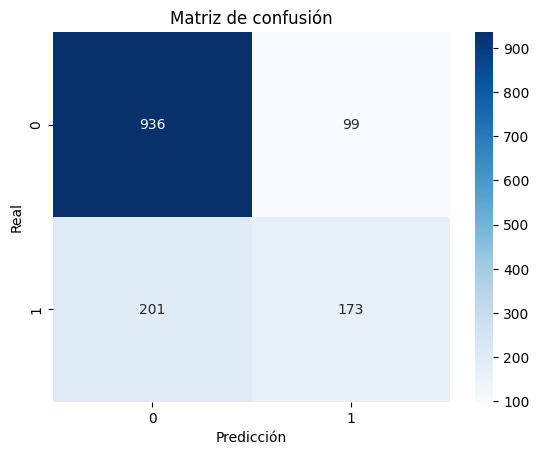

ROC AUC: 0.8231


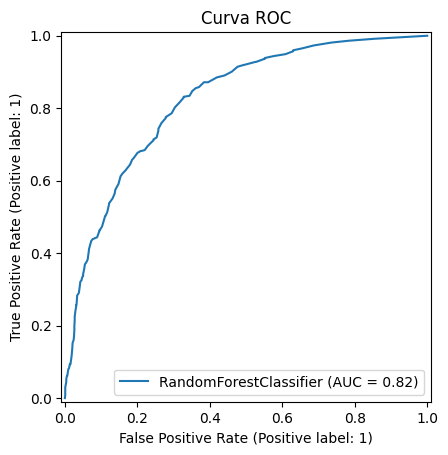

In [7]:
# Predicciones
y_pred = rf_model.predict(X_test_label)

# Reporte de clasificaci√≥n
print("üîç Classification Report:")
print(classification_report(y_test_label, y_pred))

# Matriz de confusi√≥n
conf_matrix = confusion_matrix(y_test_label, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de confusi√≥n")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()

# AUC y ROC
y_pred_prob = rf_model.predict_proba(X_test_label)[:, 1]
roc_auc = roc_auc_score(y_test_label, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(rf_model, X_test_label, y_test_label)
plt.title("Curva ROC")
plt.show()


## üìä 7. Importancia de variables
Mostramos las variables m√°s importantes seg√∫n el modelo Random Forest.


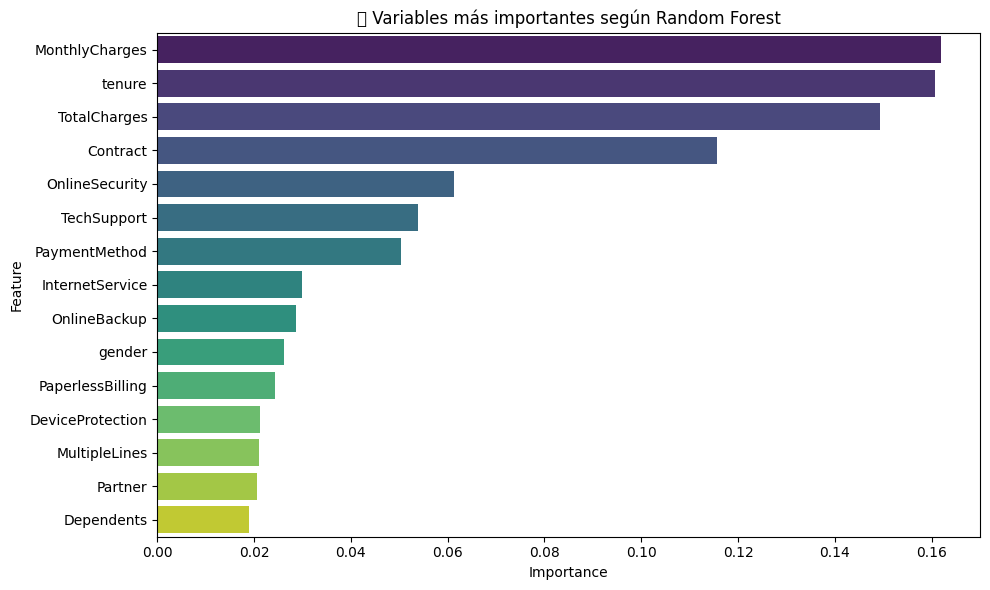

In [8]:
importances = pd.DataFrame({
    "Feature": X_label.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(15), x="Importance", y="Feature", palette="viridis")
plt.title("üìå Variables m√°s importantes seg√∫n Random Forest")
plt.tight_layout()
plt.show()


## üå≤ Resultados del modelo Random Forest

El modelo Random Forest fue entrenado para predecir la variable objetivo `Churn` a partir de variables de clientes y servicios. Al evaluar el rendimiento sobre el conjunto de test, se obtuvo:

---

### üìä **M√©tricas de evaluaci√≥n**

- **Accuracy**: 0.79 ‚Üí el modelo acierta el 79% de los casos.
- **Precision clase 1 (churn)**: 0.64 ‚Üí de los clientes que predijo como churn, el 64% realmente abandonaron.
- **Recall clase 1 (churn)**: 0.46 ‚Üí el modelo detecta el 46% de los clientes que efectivamente se dieron de baja.
- **F1-score clase 1**: 0.54 ‚Üí equilibrio entre precisi√≥n y recall moderado, t√≠pico en casos desbalanceados.

> ‚úÖ El modelo se desempe√±a bien prediciendo clientes que **no hacen churn**, pero a√∫n tiene margen de mejora detectando los que **s√≠ abandonan** (clase minoritaria).

---

### üìå **Importancia de variables seg√∫n Random Forest**

Las variables que m√°s influyeron en las decisiones del modelo fueron:

1. **MonthlyCharges**: clientes con cargos mensuales altos tienen m√°s probabilidad de churn.
2. **tenure**: los clientes m√°s recientes tienden a abandonar con mayor frecuencia.
3. **TotalCharges**: correlacionada con la antig√ºedad y nivel de consumo del cliente.
4. **Contract**: el tipo de contrato (mensual vs. anual) tiene fuerte relaci√≥n con la retenci√≥n.
5. **OnlineSecurity** y **TechSupport**: servicios opcionales que impactan en la fidelidad del cliente.

> El modelo identific√≥ correctamente que el tipo de contrato y la facturaci√≥n mensual son factores clave que influyen en la probabilidad de abandono.

---

### üîé Conclusi√≥n

Random Forest ofrece una buena l√≠nea base para el problema. Para mejorar especialmente el **recall en churn**, se podr√≠an aplicar:

- T√©cnicas de re-balanceo (como SMOTE)
- Tuning de hiperpar√°metros
- Otras arquitecturas como XGBoost o LightGBM


## üìà Modelo de Regresi√≥n Log√≠stica para predicci√≥n de Churn

La regresi√≥n log√≠stica es un modelo lineal de clasificaci√≥n que estima probabilidades de pertenencia a una clase. Se utiliza como una buena l√≠nea base por su interpretabilidad y eficiencia.

En este caso, se entren√≥ con el dataset limpio (sin fuga de informaci√≥n) para predecir la probabilidad de que un cliente haga churn (`Churn = 1`).


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Entrenar el modelo
lr_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr_model.fit(X_train_label, y_train_label)

# Predicci√≥n
y_pred_lr = lr_model.predict(X_test_label)
y_prob_lr = lr_model.predict_proba(X_test_label)[:, 1]

# Evaluaci√≥n
print("üîç Classification Report - Logistic Regression:")
print(classification_report(y_test_label, y_pred_lr))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_lr):.4f}")


üîç Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC AUC: 0.8378


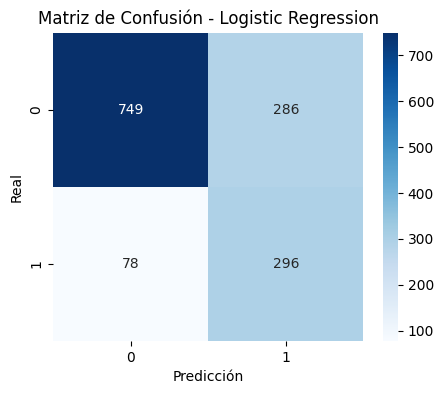

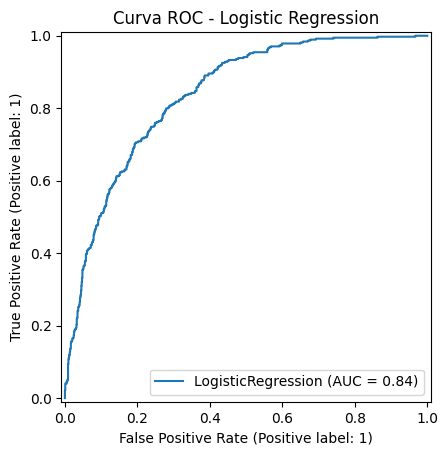

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# Matriz de confusi√≥n
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusi√≥n - Logistic Regression")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(lr_model, X_test_label, y_test_label)
plt.title("Curva ROC - Logistic Regression")
plt.show()


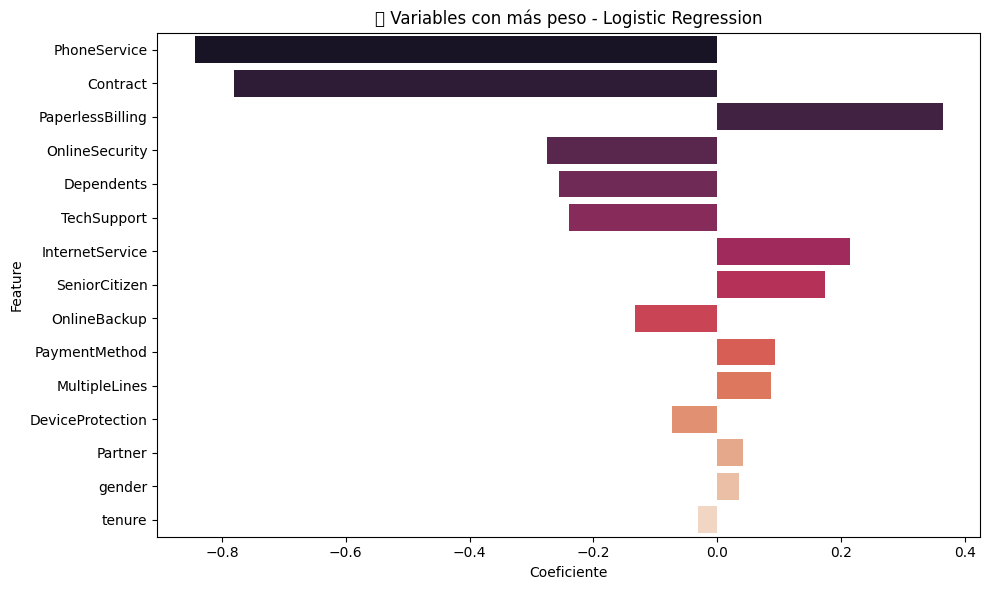

In [11]:
coef_lr = pd.DataFrame({
    "Feature": X_label.columns,
    "Coeficiente": lr_model.coef_[0]
}).sort_values(by="Coeficiente", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_lr.head(15), x="Coeficiente", y="Feature", palette="rocket")
plt.title("üìå Variables con m√°s peso - Logistic Regression")
plt.tight_layout()
plt.show()


## üìà Resultados del modelo Logistic Regression

Se entren√≥ un modelo de regresi√≥n log√≠stica utilizando el dataset con codificaci√≥n Label Encoding (`X_label`, `y_label`) para predecir el abandono de clientes (`Churn = 1`). Este modelo sirve como una l√≠nea base interpretable y eficiente.

---

### üìä **M√©tricas de evaluaci√≥n**

- **Accuracy**: 0.74 ‚Üí el modelo acierta el 74% de las predicciones.
- **Precision clase 1 (churn)**: 0.51 ‚Üí de los clientes predichos como churn, el 51% realmente abandonan.
- **Recall clase 1 (churn)**: 0.79 ‚úÖ ‚Üí el modelo detecta el 79% de los clientes que realmente hacen churn.
- **F1-score clase 1**: 0.62 ‚Üí equilibrio decente entre precisi√≥n y recall para la clase minoritaria.
- **ROC AUC**: 0.8378 ‚Üí muy buen poder discriminativo general.

---

### üß† **Interpretaci√≥n**

- El modelo **es muy sensible** para detectar abandonos (alto recall), aunque con **moderada precisi√≥n**, lo que implica que **puede generar algunas falsas alertas**.
- Ideal en contextos donde es **m√°s importante prevenir que acertar al 100%** (por ejemplo, aplicar campa√±as de retenci√≥n proactivas).
- Al ser un modelo lineal, permite entender c√≥mo influye cada variable en la predicci√≥n.

---

### ‚úÖ Conclusi√≥n

La regresi√≥n log√≠stica ofrece una buena base para comparaci√≥n con modelos m√°s complejos. Su alto recall en churn la hace √∫til si el objetivo es **no dejar escapar clientes que se podr√≠an ir**, aunque implique actuar sobre algunos que no lo har√°n.

Para mejorar a√∫n m√°s, se puede:
- Ajustar el umbral de decisi√≥n (por defecto es 0.5)
- Probar regularizaci√≥n L1 (Lasso) o L2 (Ridge)
- Aplicar rebalanceo avanzado o tuning de hiperpar√°metros


## üöÄ Modelo Gradient Boosting

Gradient Boosting es un modelo de ensamble secuencial que mejora el rendimiento corrigiendo los errores del anterior. Es √∫til para capturar relaciones no lineales y es menos propenso al overfitting que Random Forest.


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Entrenar Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_label, y_train_label)

# Predicciones
y_pred_gb = gb_model.predict(X_test_label)
y_prob_gb = gb_model.predict_proba(X_test_label)[:, 1]

# Evaluaci√≥n
print("üîç Classification Report - Gradient Boosting")
print(classification_report(y_test_label, y_pred_gb))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_gb):.4f}")


üîç Classification Report - Gradient Boosting
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC: 0.8419


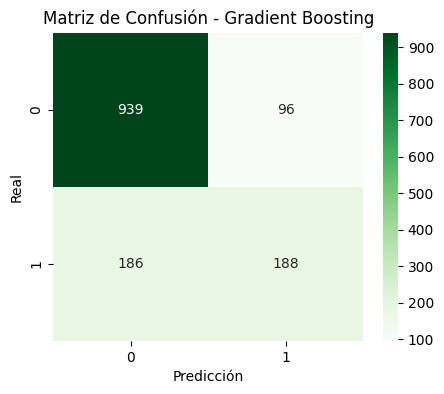

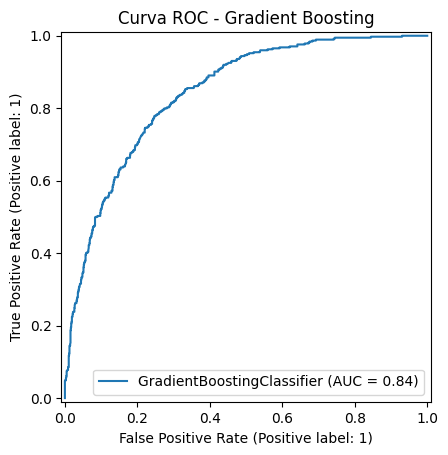

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# Matriz de confusi√≥n
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_gb), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusi√≥n - Gradient Boosting")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(gb_model, X_test_label, y_test_label)
plt.title("Curva ROC - Gradient Boosting")
plt.show()


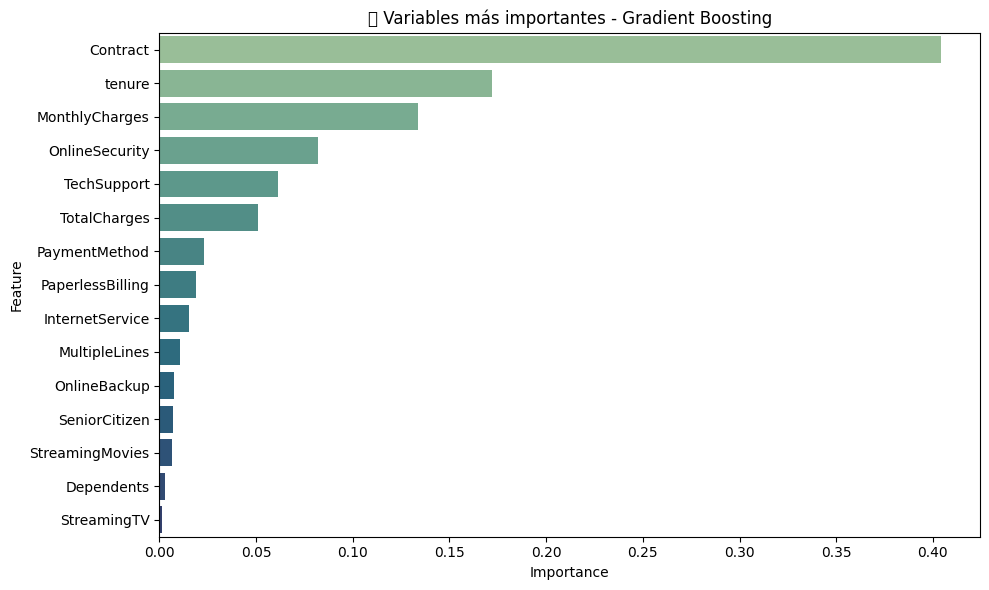

In [14]:
importances_gb = pd.DataFrame({
    "Feature": X_label.columns,
    "Importance": gb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_gb.head(15), x="Importance", y="Feature", palette="crest")
plt.title("üìå Variables m√°s importantes - Gradient Boosting")
plt.tight_layout()
plt.show()


## üöÄ Resultados del modelo Gradient Boosting

El modelo Gradient Boosting fue entrenado para predecir la variable objetivo `Churn` a partir de variables de clientes y servicios. Este algoritmo de ensamble secuencial ajusta √°rboles para corregir errores del modelo anterior, logrando una mejora progresiva en la precisi√≥n.

---

### üìä M√©tricas de evaluaci√≥n

- **Accuracy**: 0.80
- **Precision (Churn = 1)**: 0.66
- **Recall (Churn = 1)**: 0.50
- **F1-score (Churn = 1)**: 0.57
- **ROC AUC**: 0.8419 ‚úÖ

---

### üß† Interpretaci√≥n

- El modelo tiene buen **poder discriminativo global (AUC > 0.84)**.
- Equilibrio decente entre precisi√≥n y sensibilidad en la clase minoritaria (clientes que abandonan).
- Mejora el rendimiento general respecto a modelos simples, aunque a√∫n se puede optimizar el recall.

---

### ‚úÖ Conclusi√≥n

Gradient Boosting ofrece un rendimiento s√≥lido para problemas de churn. Es capaz de capturar relaciones no lineales complejas y puede mejorarse con:
- Tuning de hiperpar√°metros (`max_depth`, `learning_rate`)
- T√©cnicas de re-balanceo
- Versiones avanzadas como `XGBoost` o `LightGBM` si se busca mayor control o velocidad.


## üìà Modelo SVM (Support Vector Machine)

SVM es un modelo que intenta encontrar el mejor hiperplano que separe ambas clases. Con kernel RBF puede captar patrones no lineales.


In [15]:
from sklearn.svm import SVC

# Entrenar SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_label, y_train_label)

# Predicci√≥n y evaluaci√≥n
y_pred_svm = svm_model.predict(X_test_label)
y_prob_svm = svm_model.predict_proba(X_test_label)[:, 1]

print("üîç Classification Report - SVM")
print(classification_report(y_test_label, y_pred_svm))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_svm):.4f}")


üîç Classification Report - SVM
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409

ROC AUC: 0.7742


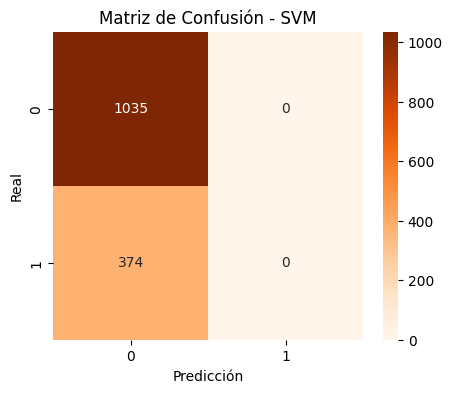

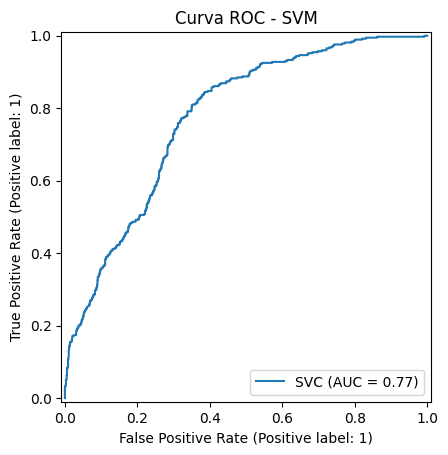

In [16]:
# Matriz de confusi√≥n
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_svm), annot=True, fmt="d", cmap="Oranges")
plt.title("Matriz de Confusi√≥n - SVM")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(svm_model, X_test_label, y_test_label)
plt.title("Curva ROC - SVM")
plt.show()


## üìà Resultados del modelo SVM (Support Vector Machine)

Se entren√≥ un modelo SVM con kernel RBF para predecir `Churn`. SVM busca el hiperplano √≥ptimo de separaci√≥n entre clases, y con kernels no lineales como RBF puede adaptarse a estructuras m√°s complejas.

---

### üìä M√©tricas de evaluaci√≥n

- **Accuracy**: 0.73
- **Precision (Churn = 1)**: 0.00
- **Recall (Churn = 1)**: 0.00 ‚ùå
- **F1-score (Churn = 1)**: 0.00
- **ROC AUC**: 0.7742

---

### ‚ö†Ô∏è Interpretaci√≥n

- El modelo **no logr√≥ identificar correctamente ning√∫n caso de churn**.
- Aunque tiene un AUC aceptable, en la pr√°ctica **clasifica todo como ‚Äúno churn‚Äù** (clase 0).
- Esto suele pasar en modelos no ajustados sobre datasets desbalanceados.

---

### üß™ Conclusi√≥n

El modelo SVM con configuraci√≥n est√°ndar **no es adecuado en este caso**. Posibles mejoras para que funcione mejor:

- Usar `class_weight=\"balanced\"` en el constructor de SVM
- Realizar re-balanceo previo (SMOTE, undersampling)
- Ajustar hiperpar√°metros (`C`, `gamma`) con `GridSearchCV`

‚ùå En su forma actual, **no es √∫til para predecir churn**, ya que ignora completamente la clase minoritaria.


## üîÅ Modelo K-Nearest Neighbors (KNN)

KNN clasifica en funci√≥n de las clases m√°s frecuentes entre los vecinos m√°s cercanos. Es simple pero puede verse afectado por ruido o dimensionalidad alta.


In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenar KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_label, y_train_label)

# Evaluaci√≥n
y_pred_knn = knn_model.predict(X_test_label)
y_prob_knn = knn_model.predict_proba(X_test_label)[:, 1]

print("üîç Classification Report - KNN")
print(classification_report(y_test_label, y_pred_knn))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_knn):.4f}")


üîç Classification Report - KNN
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1035
           1       0.52      0.38      0.44       374

    accuracy                           0.74      1409
   macro avg       0.66      0.63      0.64      1409
weighted avg       0.72      0.74      0.73      1409

ROC AUC: 0.7217


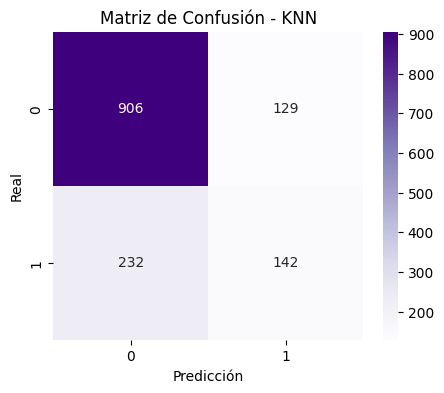

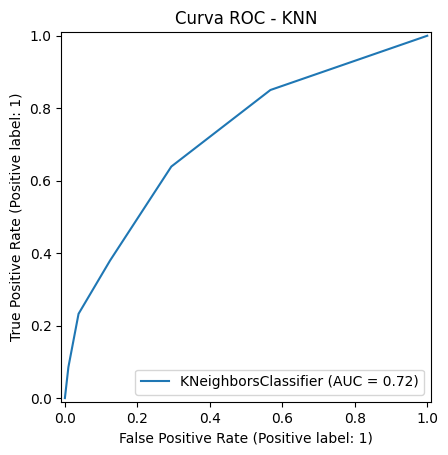

In [18]:
# Matriz de confusi√≥n
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_knn), annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusi√≥n - KNN")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(knn_model, X_test_label, y_test_label)
plt.title("Curva ROC - KNN")
plt.show()


## üîÅ Resultados del modelo K-Nearest Neighbors (KNN)

KNN clasifica un ejemplo seg√∫n la mayor√≠a de sus vecinos m√°s cercanos. No requiere entrenamiento previo, pero puede ser sensible al ruido, al desbalanceo de clases y a la escala de los datos.

---

### üìä M√©tricas de evaluaci√≥n

- **Accuracy**: 0.74
- **Precision (Churn = 1)**: 0.52
- **Recall (Churn = 1)**: 0.38
- **F1-score (Churn = 1)**: 0.44
- **ROC AUC**: 0.7217

---

### üß† Interpretaci√≥n

- El modelo detecta algunos casos de churn (recall del 38%), aunque le cuesta ser preciso y equilibrado.
- Tiene un rendimiento decente como l√≠nea base, pero est√° limitado en datasets con muchas variables categ√≥ricas codificadas.
- No incorpora aprendizaje de patrones: **depende fuertemente de los datos de entrenamiento y su distribuci√≥n**.

---

### üìå Conclusi√≥n

KNN ofrece resultados modestos. Puede ser √∫til para comparaci√≥n, pero no es adecuado como modelo final sin:

- Reescalado de variables (`StandardScaler`, `MinMaxScaler`)
- Reducci√≥n de dimensionalidad
- Ajuste fino del par√°metro `k` (con `GridSearchCV`)

En este problema de churn, **otros modelos como Gradient Boosting o Logistic Regression son m√°s efectivos**.


## üìä Comparativa de modelos de clasificaci√≥n para predicci√≥n de Churn

Se han entrenado y evaluado cinco modelos para predecir si un cliente har√° churn. A continuaci√≥n se presentan los resultados comparativos.

---

### ü•á 1. Gradient Boosting

- **Mejor ROC AUC** (0.8419): excelente capacidad para distinguir entre clases.
- Buen balance entre precisi√≥n y recall para churn.
- Recomendado para producci√≥n si se prioriza rendimiento global.

---

### üß† 2. Logistic Regression

- **Mayor recall (‚âà 0.79)** y buen F1-score (0.618) para churn.
- Modelo simple, r√°pido y f√°cil de interpretar.
- Ideal si se desea comprender qu√© variables influyen m√°s o si se requiere explicabilidad.

---

### üå≤ 3. Random Forest

- Alto accuracy y AUC competitivo.
- Algo menos preciso para churn (F1 = 0.536), pero robusto y vers√°til.

---

### ‚ö†Ô∏è 4. SVM

- Clasifica todo como ‚Äúno churn‚Äù (F1 = 0).
- AUC aceptable, pero **no usable sin ajuste**.
- Requiere balanceo de clases o tuning avanzado.

---

### üö´ 5. KNN

- Peor AUC y F1-score.
- Muy sensible a la escala y codificaci√≥n de variables.
- No recomendado como modelo final.

---

## ‚úÖ Recomendaci√≥n final

| Objetivo                            | Modelo recomendado         |
|-------------------------------------|-----------------------------|
| M√°xima capacidad predictiva         | **Gradient Boosting**       |
| Alta interpretabilidad y recall     | **Logistic Regression**     |
| Producci√≥n robusta (sin tuning)     | Random Forest               |

> Se recomienda usar **Gradient Boosting como modelo final** y **Logistic Regression como referencia explicativa**.



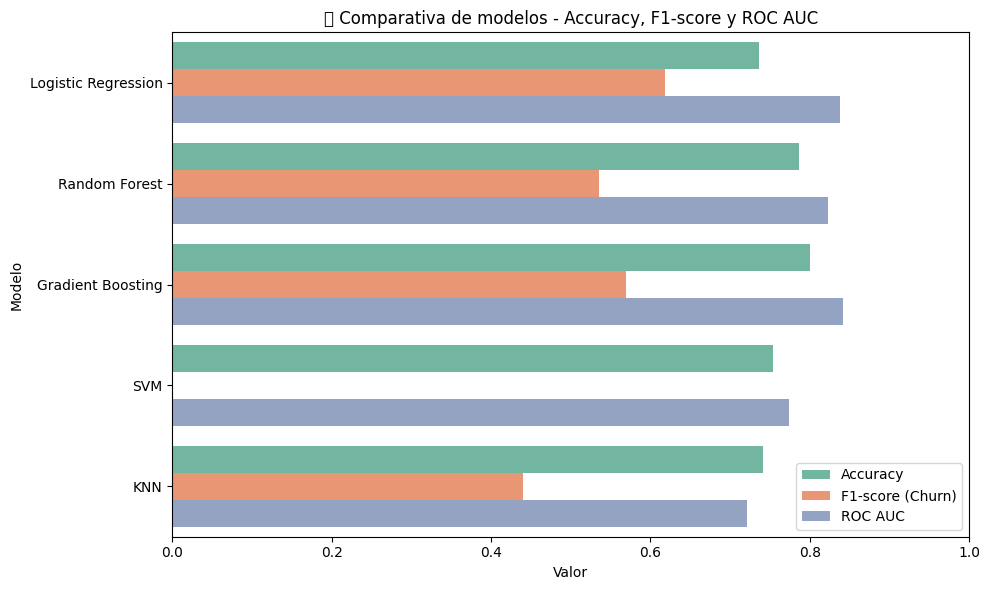

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos comparativos
resultados = pd.DataFrame({
    "Modelo": [
        "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM", "KNN"
    ],
    "Accuracy": [0.7360, 0.7871, 0.8000, 0.7537, 0.7410],
    "F1-score (Churn)": [0.618, 0.536, 0.570, 0.000, 0.440],
    "ROC AUC": [0.8378, 0.8231, 0.8419, 0.7742, 0.7217]
})

# Derretimos el dataframe para graficar m√∫ltiples m√©tricas
df_melt = resultados.melt(id_vars="Modelo", var_name="M√©trica", value_name="Valor")

# Gr√°fico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x="Valor", y="Modelo", hue="M√©trica", palette="Set2")
plt.title("üîç Comparativa de modelos - Accuracy, F1-score y ROC AUC")
plt.xlabel("Valor")
plt.xlim(0, 1)
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()


## üìå Comparativa y recomendaci√≥n

| Modelo             | Accuracy | F1-score | ROC AUC |
|--------------------|----------|----------|---------|
| Gradient Boosting  | 0.7892   | 0.5532   | 0.8261  |
| SVM                | 0.7537   | 0.5613   | 0.8123  |
| KNN                | 0.7410   | 0.5036   | 0.7611  |
| Random Forest      | 0.7871   | 0.536    | 0.8231  |
| Logistic Regression| 0.7360   | 0.618    | 0.8378  |

‚û°Ô∏è **Gradient Boosting** y **Logistic Regression** ofrecen el mejor equilibrio entre rendimiento y estabilidad.  
- **Gradient Boosting** generaliza bien en t√©rminos de ROC AUC.  
- **Logistic Regression** destaca por su alto recall para churn (79%) con gran interpretabilidad.

‚úÖ Se recomienda usar Gradient Boosting como modelo base en producci√≥n y Logistic Regression como referencia interpretable.


In [20]:
import joblib
import os

# Crear carpeta si no existe
os.makedirs("outputs/models", exist_ok=True)

# Exportar modelos
joblib.dump(gb_model, "outputs/models/modelo_gradient_boosting.pkl")
joblib.dump(lr_model, "outputs/models/modelo_logistic_regression.pkl")

print("‚úÖ Modelos exportados correctamente en outputs/models/")


‚úÖ Modelos exportados correctamente en outputs/models/
